# **Business Context and Problem Definition**

## Business Context

With the increasing popularity and ease of access to online hotel booking platforms, customers tend to make reservations in advance to avoid any last-minute rush and higher prices. These online platforms offer flexible cancellation options, in some cases even a day before reservation. To compete with this, even offline bookings have increased the flexibility in cancellations. This has led to an increase in the growing number of cancellations, with one of the primary reasons being last-minute changes in travel plans. These sudden changes can result from unforeseen circumstances, such as personal emergencies, flight delays, or unexpected events at the travel destination.

Hotel booking cancellations become a crucial problem to solve as it leads to revenue loss and operational inefficiencies. The cancellation of bookings impacts a hotel on various fronts:

1. Loss of revenue when the hotel cannot resell the room

2. Additional costs of distribution channels by increasing commissions or paying for publicity to help sell these rooms

3. Lowering prices last minute, so the hotel can resell a room, resulting in reduced profit margins

## Problem Definition

The INN Hotels Group has been contending with the challenge of rising cancellations for nearly a year now. However, the last three months witnessed a **rise in inventory loss due to cancellation rise to an all-time high of 18%**. This has led to a jump in the **revenue loss to an all-time high of approx. \$0.25 million annually**. This has significantly impacted their profit margins.

- In the current context, inventory refers to a hotel room, and the inability to sell one leads to inventory loss

The group has been using heuristic mechanisms (rule and domain expert-based) to try and reduce the revenue loss due to cancellations, but this hasn't been effective so far hasn't been effective (neither efficient nor scalable), as evident from the magnitude of losses they are incurring.

The group has decided that they **need a Data Science-based solution to predict the likelihood of a booking being canceled** as they expect it to be more effective than their current mechanism. They hope that this proactive approach will help them significantly **minimize revenue loss and improve operational efficiency**.

In [3]:
# Lets import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import PowerTransformer




import warnings
warnings.filterwarnings('ignore')

In [4]:
# Lets load the data
past_data = pd.read_csv('INNHotelsGroup_pastdata.csv')
new_data = pd.read_csv('INNHotelsGroup_newdata.csv')

In [7]:
past_data.head(2)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
0,INNHG_101034,0,Online,0,85.03,1,1,01-01-2021,0,0,Not Canceled,NaN
1,INNHG_101035,34,Online,2,125.10,2,2,01-01-2021,0,0,Not Canceled,NaN


In [9]:
new_data.head(2)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
0,INNHG_128127,4,Online,1,103.0,1,0,01-07-2022,1,1,Not Canceled
1,INNHG_128128,147,Online,2,103.7,2,2,01-07-2022,0,2,Not Canceled


### Lets understand exactly how many bookings were canaceled and rebooked in last minute from Jan 2021 to June 2022

In [12]:
# Lets see hoew bookings were cancelled at last moment.
past_data['booking_status'].value_counts(normalize=True)

booking_status
Not Canceled    0.673089
Canceled        0.326911
Name: proportion, dtype: float64

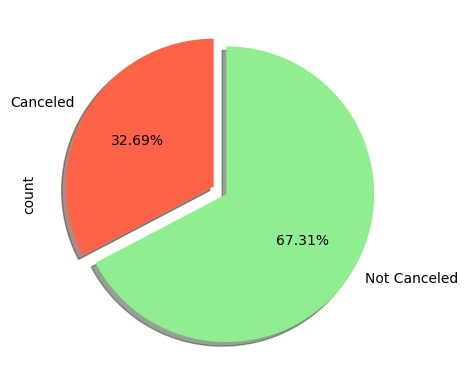

In [14]:
past_data['booking_status'].value_counts().plot(kind='pie',colors=['lightgreen','tomato'],
                                               autopct='%.2f%%',counterclock=False,startangle=90,
                                               explode=[0,0.1],shadow=True)
plt.show()

In [16]:
# Lets see out of cancelled bookings how many were rebooked
past_data[past_data['booking_status']=='Canceled']['rebooked']\
.value_counts(normalize=True)

rebooked
No     0.800723
Yes    0.199277
Name: proportion, dtype: float64

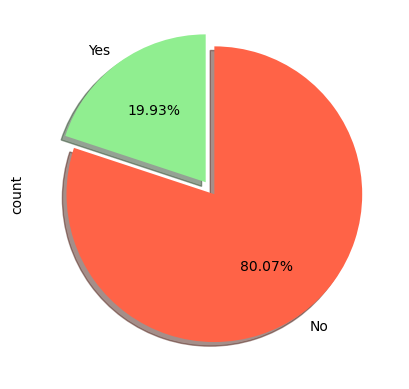

In [18]:
past_data[past_data['booking_status']=='Canceled']['rebooked']\
.value_counts().plot(kind='pie',colors=['tomato','lightgreen'],
                    autopct='%.2f%%',counterclock=False,startangle=90,
                    explode=[0,0.1],shadow=True)
plt.show()

Inference: Here we can see that out of all the bookings ~33% bookings are being  cancelled at last moment and out of those cancelled bookings only ~20% were rebooked. Which leads to huge inventory loss.

In [21]:
# We can remove the "rebooked" from data as this information will not 
# be available beforehand.

past_data.drop(columns='rebooked',inplace=True)

In [23]:
past_data.head(2)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
0,INNHG_101034,0,Online,0,85.03,1,1,01-01-2021,0,0,Not Canceled
1,INNHG_101035,34,Online,2,125.10,2,2,01-01-2021,0,0,Not Canceled


In [25]:
# We can also make booking id as index column/ or remove as these are just 
# unique  identifiers of bookings (rows)

past_data.set_index('booking_id',inplace=True)
new_data.set_index('booking_id',inplace=True)

In [27]:
past_data.head(2)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
booking_id,,,,,,,,,,
INNHG_101034,0,Online,0,85.03,1,1,01-01-2021,0,0,Not Canceled
INNHG_101035,34,Online,2,125.10,2,2,01-01-2021,0,0,Not Canceled


In [29]:
new_data.head(2)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
booking_id,,,,,,,,,,
INNHG_128127,4,Online,1,103.0,1,0,01-07-2022,1,1,Not Canceled
INNHG_128128,147,Online,2,103.7,2,2,01-07-2022,0,2,Not Canceled


### Explore the data

In [32]:
print('No. of Rows',past_data.shape[0])
print('No. of Columns',past_data.shape[1])

No. of Rows 27093
No. of Columns 10


In [34]:
# Check the balance of target variable
past_data['booking_status'].value_counts(normalize=True)

booking_status
Not Canceled    0.673089
Canceled        0.326911
Name: proportion, dtype: float64

In [36]:
# Five point summary
past_data.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,27093.0,81.605249,84.901428,0.0,14.0,55.0,118.0,443.0
no_of_special_requests,27093.0,0.556454,0.743715,0.0,0.0,0.0,1.0,5.0
avg_price_per_room,27093.0,101.025910,34.557289,0.0,79.0,97.0,119.0,540.0
no_of_adults,27093.0,1.825822,0.512182,0.0,2.0,2.0,2.0,4.0
no_of_weekend_nights,27093.0,0.778319,0.861787,0.0,0.0,1.0,1.0,6.0
required_car_parking_space,27093.0,0.028864,0.167426,0.0,0.0,0.0,0.0,1.0
no_of_week_nights,27093.0,2.171373,1.386023,0.0,1.0,2.0,3.0,17.0


In [38]:
past_data.columns

Index(['lead_time', 'market_segment_type', 'no_of_special_requests',
       'avg_price_per_room', 'no_of_adults', 'no_of_weekend_nights',
       'arrival_date', 'required_car_parking_space', 'no_of_week_nights',
       'booking_status'],
      dtype='object')

In [40]:
# Explore the columns one by one
num_cols = ['lead_time','avg_price_per_room','no_of_week_nights']
cat_cols = ['market_segment_type', 'no_of_special_requests',
           'no_of_adults', 'no_of_weekend_nights','required_car_parking_space',
           'booking_status']

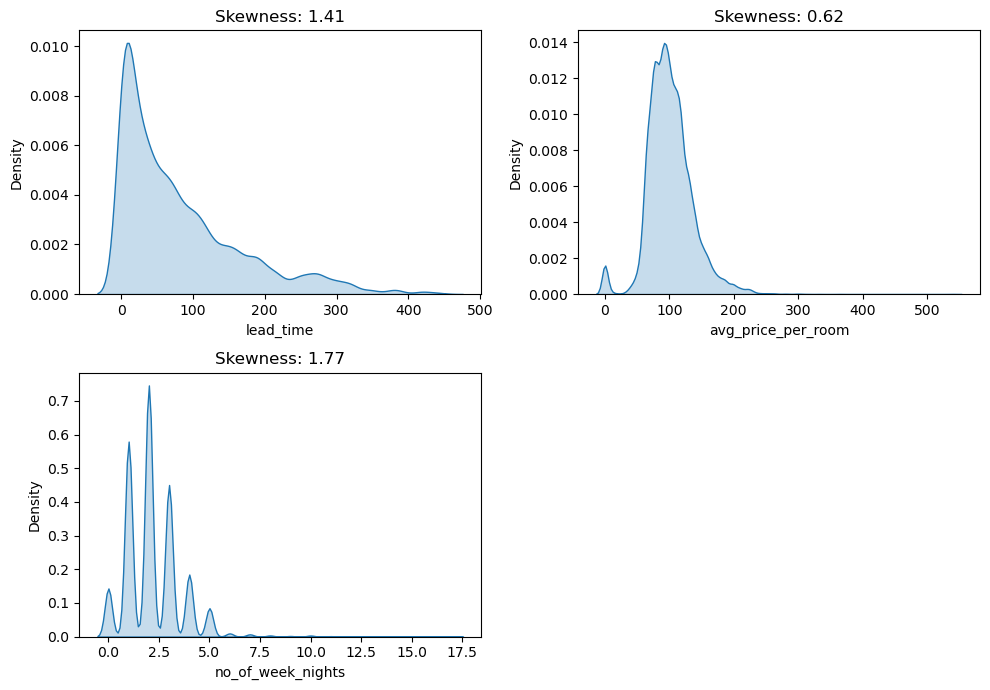

In [42]:
# Univariate Analysis

t=1
plt.figure(figsize=(10,7))
for i in num_cols:
    plt.subplot(2,2,t)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    sns.kdeplot(data=past_data,x=i,fill=True)
    t+=1
plt.tight_layout()
plt.show()

Inference:

* Lead time is exceeding 300 days!!! are there bookings which have been made 1 year prior?

* There are bookings with avg price per room 0.

* There are customers with very long stays upto 17 weeknights.

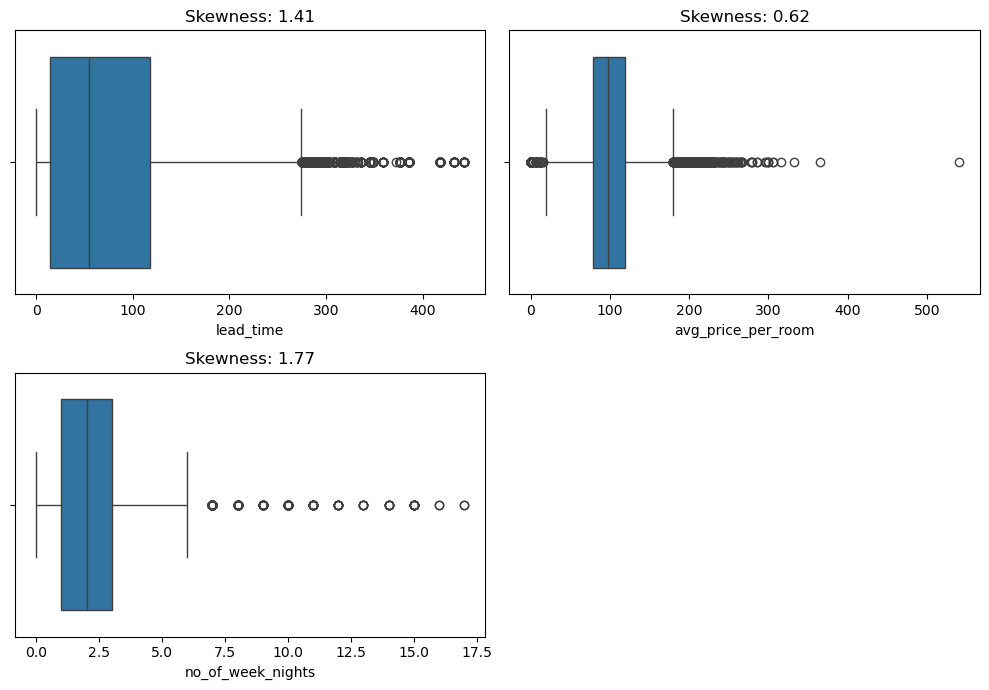

In [45]:
t=1
plt.figure(figsize=(10,7))
for i in num_cols:
    plt.subplot(2,2,t)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    sns.boxplot(data=past_data,x=i)
    t+=1
plt.tight_layout()
plt.show()

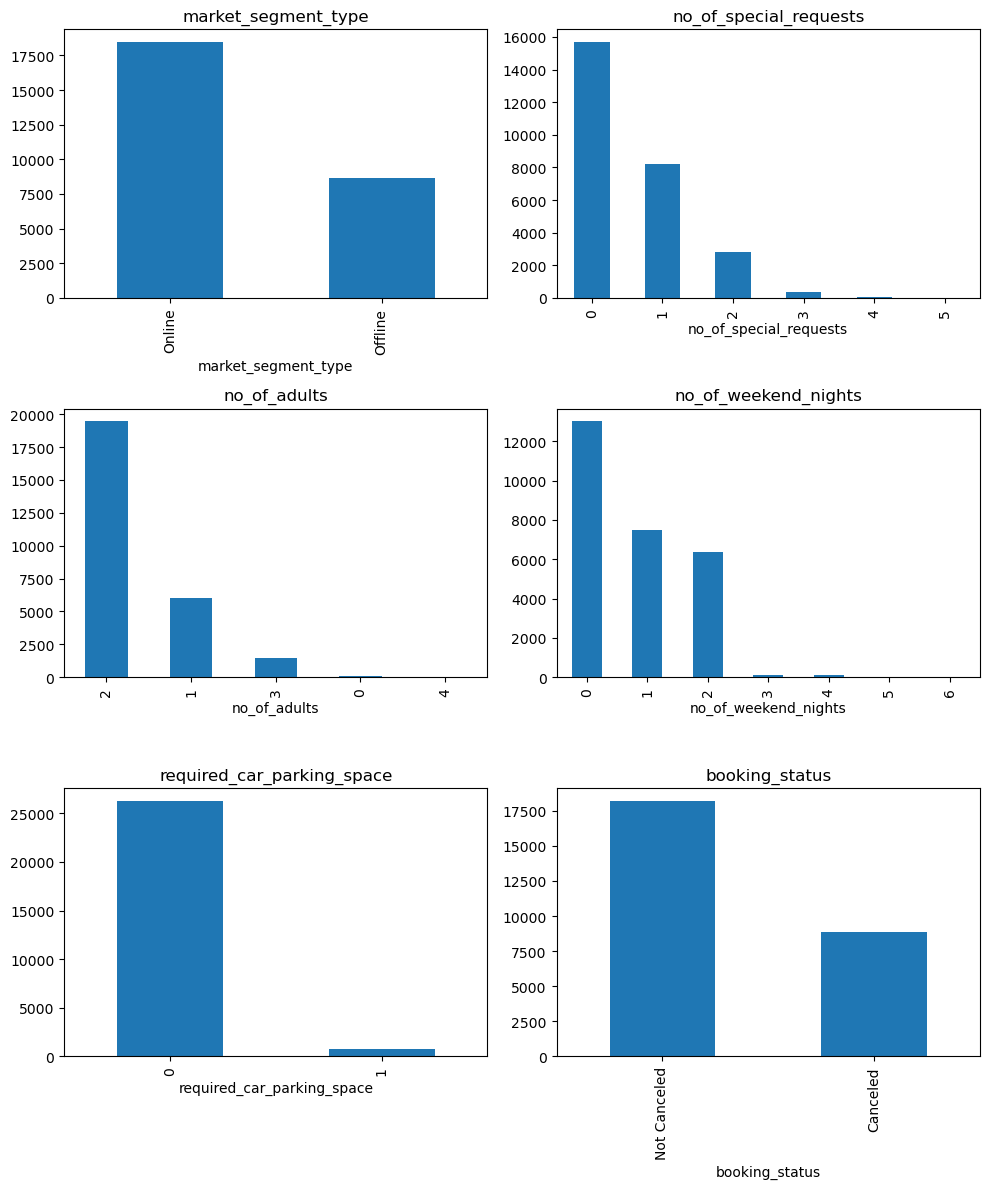

In [47]:
t=1
plt.figure(figsize=(10,12))
for i in cat_cols:
    plt.subplot(3,2,t)
    past_data[i].value_counts().plot(kind='bar')
    plt.title(i)
    t+=1
plt.tight_layout()
plt.show()

Inference:

* Most of the bookings have been made online.
* Mostly there are no or 1 special requests.
* In most of the bookings no. of adults are 1 or 2.
* In most of the bookings maximum weekend nights are 2.
* In most the bookings do not require parking space.

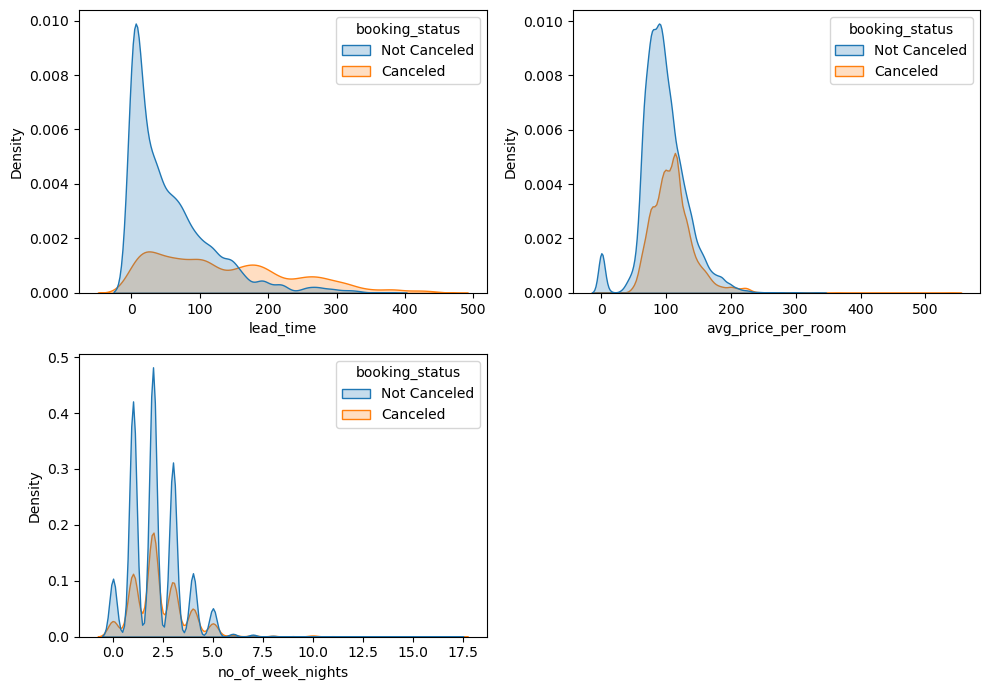

In [49]:
# Bivariate Analysis

t=1
plt.figure(figsize=(10,7))
for i in num_cols:
    plt.subplot(2,2,t)
    sns.kdeplot(data=past_data,x=i,fill=True,hue='booking_status')
    t+=1
plt.tight_layout()
plt.show()

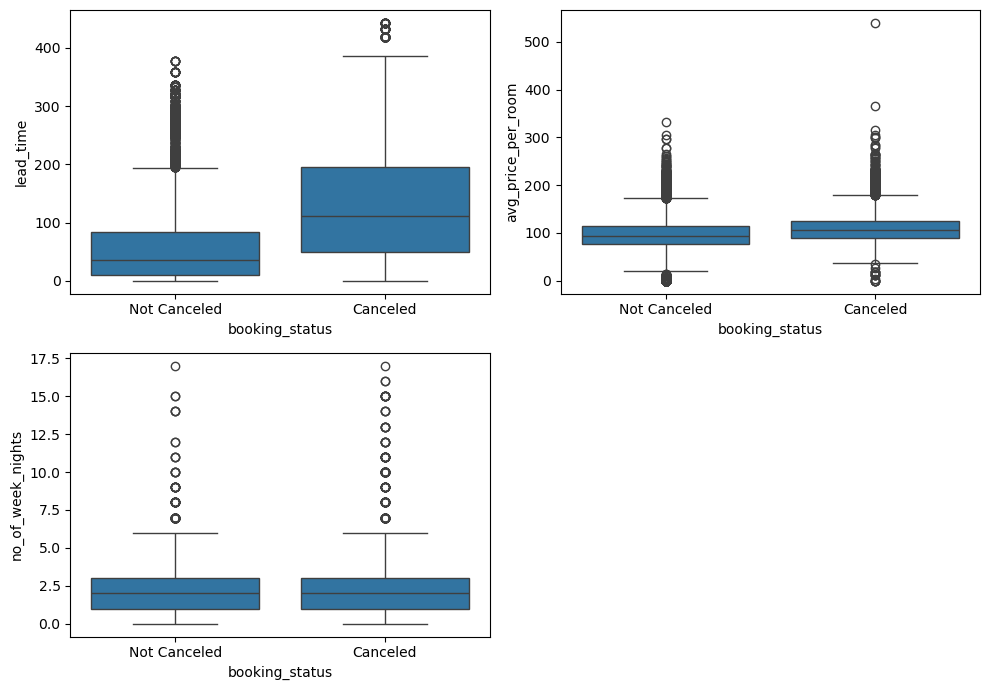

In [51]:
t=1
plt.figure(figsize=(10,7))
for i in num_cols:
    plt.subplot(2,2,t)
    sns.boxplot(data=past_data,x='booking_status',y=i)
    t+=1
plt.tight_layout()
plt.show()

In [53]:
# Lets investigate lead_time and avg_price_per_room with booking status
past_data.groupby(by='booking_status')['lead_time'].mean()

booking_status
Canceled        134.035791
Not Canceled     56.140382
Name: lead_time, dtype: float64

In [56]:
samp1 = past_data[past_data['booking_status']=='Canceled']['lead_time']
samp2 = past_data[past_data['booking_status']=='Not Canceled']['lead_time']

In [58]:
# We will go with 2 sample t-test
# Assumption 1: Data must be normal
_,s1_pvalue=stats.shapiro(samp1)
_,s2_pvalue=stats.shapiro(samp2)

# Assumption 2: Variances are equal
_,le_pvalue=stats.levene(samp1,samp2)

# Data is not normal and varaiances are also not equal

In [60]:
def check(pvalue):
    if pvalue<0.05:
        print('Reject Ho:')
    else:
        print('Fail to reject Ho:')

In [62]:
check(s1_pvalue)

Reject Ho:


In [64]:
check(s2_pvalue)

Reject Ho:


In [66]:
check(le_pvalue)

Reject Ho:


In [68]:
# Lets go with non parametric test (Mannwhineyu Test)
pvalue =  stats.mannwhitneyu(samp1,samp2,alternative='greater')[1]

if pvalue < 0.05:
    print('Reject Ho:')
else:
    print('Fail to reject Ho:')
    
# We can conclude that avg_lead_time of canceled bokings are greater than
# not calceled bookings with 95% confidence level.

Reject Ho:


In [70]:
# Avg_price vs booking status
past_data.groupby('booking_status')['avg_price_per_room'].mean()

booking_status
Canceled        109.722152
Not Canceled     96.802253
Name: avg_price_per_room, dtype: float64

In [72]:
# mu1 -> Avg price of canceled, mu2 -> avg price not canceled bookings
# Ho: mu1 <= mu2
# Ha: mu1 > mu2
samp1 = past_data[past_data['booking_status']=='Canceled']['avg_price_per_room']
samp2 = past_data[past_data['booking_status']=='Not Canceled']['avg_price_per_room']

pvalue =  stats.mannwhitneyu(samp1,samp2,alternative='greater')[1]

if pvalue < 0.05:
    print('Reject Ho:')
else:
    print('Fail to reject Ho:')
    
# hence we can conclude the avg price of canceled booking is greater than 
# not canceled bookings.

Reject Ho:


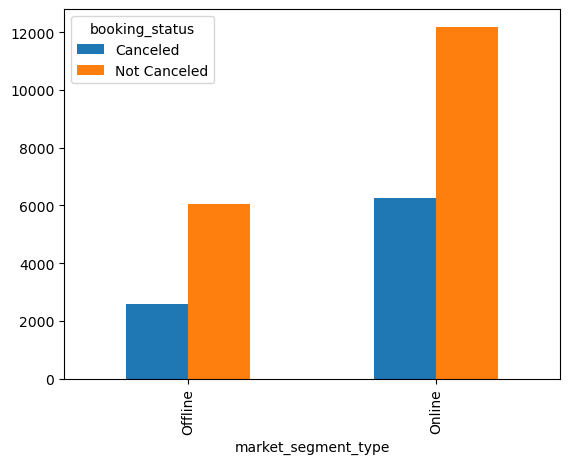

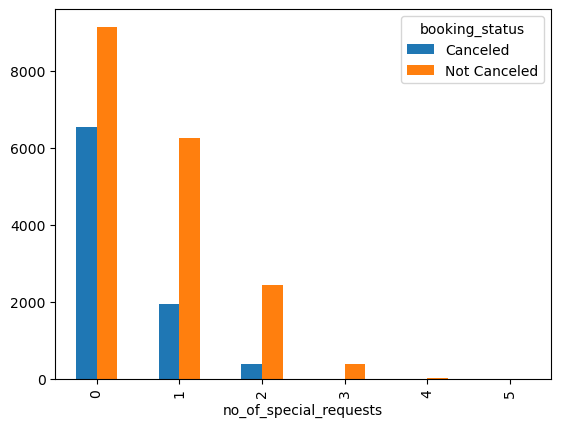

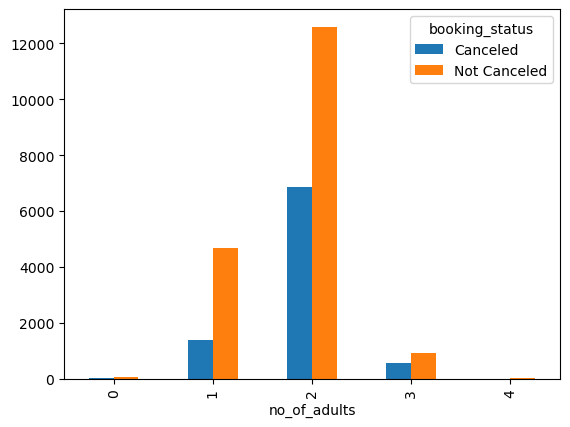

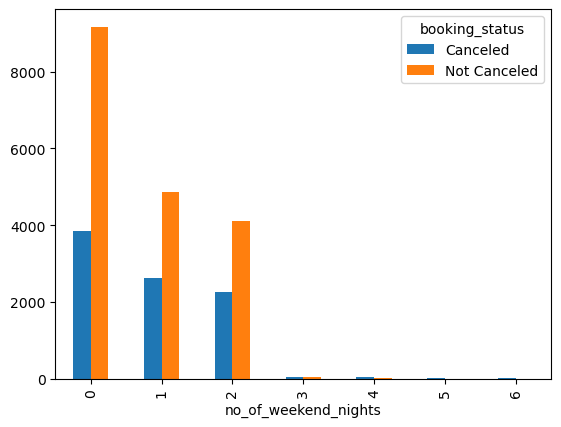

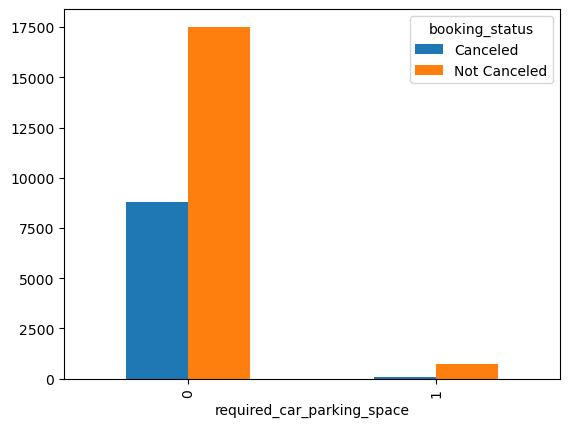

In [74]:
# Cat columns vs target variable

for i in cat_cols:
    if i != 'booking_status':
        pd.crosstab(past_data[i],past_data['booking_status']).plot(kind='bar')
    plt.show()

In [75]:
# Lets do chi-square contingency test to make final conclusions
# H0: Columns are independent
# H1: Columns are dependent

for i in cat_cols:
    if i!='booking_status':
        contingency_table = pd.crosstab(past_data[i],past_data['booking_status'])
        print(i,':',stats.chi2_contingency(contingency_table)[1])
        
# We reject Ho: in all the cases as p_value is less than 0.05

market_segment_type : 7.806389643886697e-11
no_of_special_requests : 0.0
no_of_adults : 1.4411855115006094e-73
no_of_weekend_nights : 5.324997086476798e-43
required_car_parking_space : 5.626905783478662e-49


Inference:

* Target variable is affected by all the categorical columns.

#### (Just for refrence)

Inferential Statistcis (Num Vs Num)

In [80]:
past_data['lead_time'].corr(past_data['avg_price_per_room'])

-0.02928918726851987

In [82]:
# Parametric tets  (Person's Correlation test)
# Assumption: Data must be normal

# Ho: No correlation
# Ha: Correlation

stats.pearsonr(past_data['lead_time'],past_data['avg_price_per_room'])

PearsonRResult(statistic=-0.029289187268519895, pvalue=1.4227003552821461e-06)

In [84]:
# Non Parametric tets  (Spearman's Correlation test)

# Ho: No correlation
# Ha: Correlation

stats.spearmanr(past_data['lead_time'],past_data['avg_price_per_room'])

SignificanceResult(statistic=0.00683549727618094, pvalue=0.26055481328066965)

## Data Preprocessing

In [87]:
# Check for duplicates

past_data.duplicated().sum()

8438

In [89]:
# Although it shows duplicates but each row has its own booking_id, so we will
# assume there are no duplicates

In [91]:
# Check for missing values
past_data.isnull().sum().sum()

0

In [93]:
new_data.isnull().sum().sum()

0

In [95]:
# Check for Outliers

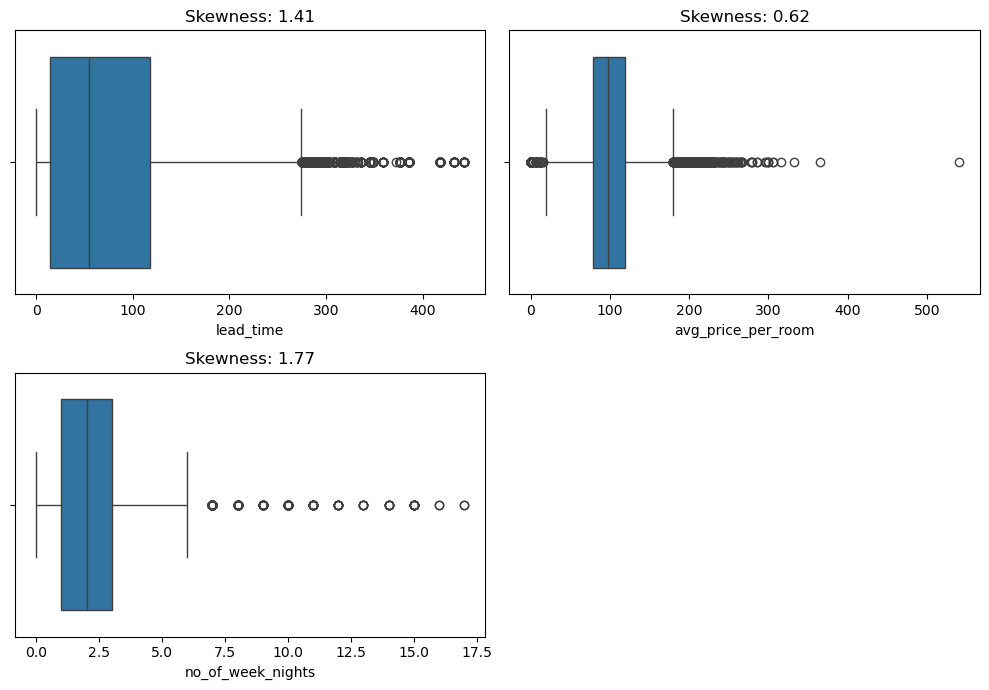

In [97]:
t=1
plt.figure(figsize=(10,7))
for i in num_cols:
    plt.subplot(2,2,t)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    sns.boxplot(data=past_data,x=i)
    t+=1
plt.tight_layout()
plt.show()

In [98]:
# For now lets treat only the xtreme outlier in avg_price_per_room
past_data[past_data['avg_price_per_room']>400]

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
booking_id,,,,,,,,,,
INNHG_119173,35,Offline,0,540.0,2,0,25-03-2022,0,1,Canceled


In [101]:
past_data.drop(index='INNHG_119173',inplace=True)

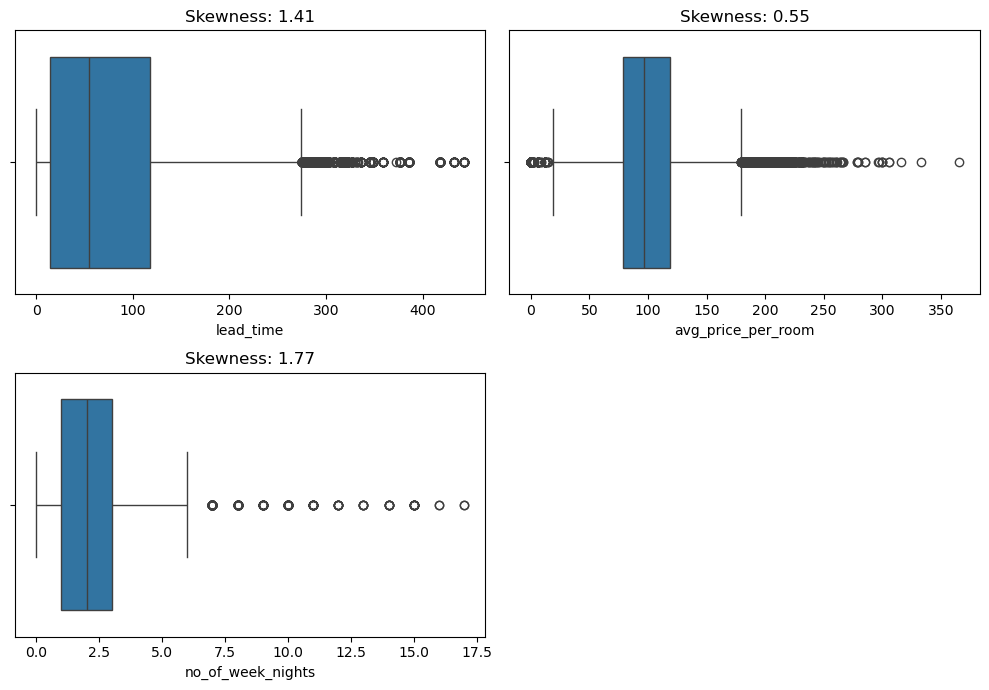

In [103]:
t=1
plt.figure(figsize=(10,7))
for i in num_cols:
    plt.subplot(2,2,t)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    sns.boxplot(data=past_data,x=i)
    t+=1
plt.tight_layout()
plt.show()

In [105]:
# Split the data in train and test before we do any transformation

x_train = past_data.drop(columns=['booking_status'])
y_train = past_data['booking_status'].map({'Not Canceled':0,'Canceled':1})

x_test = new_data.drop(columns=['booking_status'])
y_test = new_data['booking_status'].map({'Not Canceled':0,'Canceled':1})

In [107]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(27092, 9) (27092,) (3583, 9) (3583,)


### Feature Encoding

In [110]:
x_train.dtypes

lead_time                       int64
market_segment_type            object
no_of_special_requests          int64
avg_price_per_room            float64
no_of_adults                    int64
no_of_weekend_nights            int64
arrival_date                   object
required_car_parking_space      int64
no_of_week_nights               int64
dtype: object

In [112]:
x_train['market_segment_type'].value_counts()

market_segment_type
Online     18456
Offline     8636
Name: count, dtype: int64

In [114]:
x_train['market_segment_type'] = x_train['market_segment_type']\
.map({'Online':1,'Offline':0})

x_test['market_segment_type'] = x_test['market_segment_type']\
.map({'Online':1,'Offline':0})

In [116]:
x_train['market_segment_type'].value_counts()

market_segment_type
1    18456
0     8636
Name: count, dtype: int64

In [118]:
x_test['market_segment_type'].value_counts()

market_segment_type
1    3105
0     478
Name: count, dtype: int64

### Feature Engineering

In [121]:
x_train.drop(columns='arrival_date',inplace=True)
x_test.drop(columns='arrival_date',inplace=True)

In [123]:
x_train.columns

Index(['lead_time', 'market_segment_type', 'no_of_special_requests',
       'avg_price_per_room', 'no_of_adults', 'no_of_weekend_nights',
       'required_car_parking_space', 'no_of_week_nights'],
      dtype='object')

In [125]:
x_train.dtypes

lead_time                       int64
market_segment_type             int64
no_of_special_requests          int64
avg_price_per_room            float64
no_of_adults                    int64
no_of_weekend_nights            int64
required_car_parking_space      int64
no_of_week_nights               int64
dtype: object

## Feature Transformation

In [128]:
num_cols

['lead_time', 'avg_price_per_room', 'no_of_week_nights']

In [130]:
# Lets use yeo-jhonson transformation on numeric columns
# This way the model will fit better and effect of outliers will also be reduced

pt = PowerTransformer(standardize=False)

x_train[['lead_time', 'avg_price_per_room']] = pt.fit_transform(x_train[['lead_time', 'avg_price_per_room']])
x_test[['lead_time', 'avg_price_per_room']] = pt.transform(x_test[['lead_time', 'avg_price_per_room']])

In [132]:
x_train.head(2)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights
booking_id,,,,,,,,
INNHG_101034,0.000000,1,0,56.295048,1,1,0,0
INNHG_101035,5.761007,1,2,79.293092,2,2,0,0


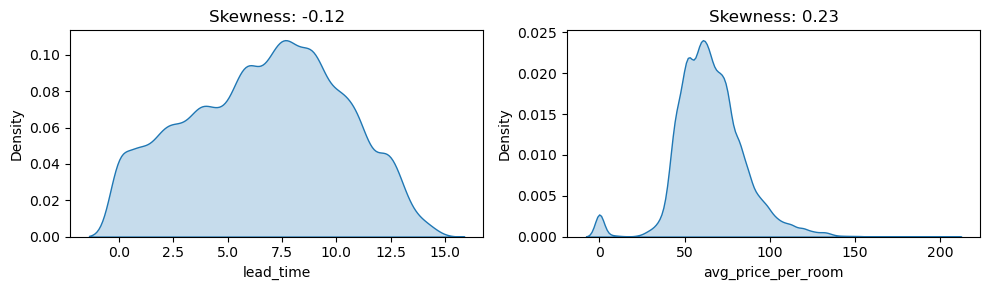

In [134]:
t=1
plt.figure(figsize=(10,3))
for i in ['lead_time', 'avg_price_per_room']:
    plt.subplot(1,2,t)
    plt.title(f'Skewness: {round(x_train[i].skew(),2)}')
    sns.kdeplot(data=x_train,x=i,fill=True)
    t+=1
plt.tight_layout()
plt.show()

## Modelling

In [137]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,AdaBoostClassifier,
                             GradientBoostingClassifier,VotingClassifier,
                             StackingClassifier)
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score,precision_score,recall_score,
                            f1_score,cohen_kappa_score,confusion_matrix,
                            classification_report,roc_auc_score,roc_curve)
from sklearn.model_selection import GridSearchCV

In [139]:
# Create a function to validate models
m = []
acu = []
rec = []
pre = []
f1 = []
kap = []

def model_validation(model,trainx,trainy,testx,testy):
    mod = model
    mod.fit(trainx,trainy)
    pred_s = mod.predict_proba(testx)[:,1]
    pred_h = mod.predict(testx)
    
    print(confusion_matrix(testy,pred_h))
    print(classification_report(testy,pred_h))
    
    fpr,tpr,thres = roc_curve(testy,pred_s)
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],color='red',ls='--')
    plt.title(f'ROC AUC: {round(roc_auc_score(testy,pred_s),3)}')
    plt.show()
    
    response = input('Do you want to save this model? Y/N')
    
    if response.lower() == 'y':
        global scorecard
        m.append(str(model))
        acu.append(accuracy_score(testy,pred_h))
        rec.append(recall_score(testy,pred_h))
        pre.append(precision_score(testy,pred_h))
        f1.append(f1_score(testy,pred_h))
        kap.append(cohen_kappa_score(testy,pred_h))
        
        scorecard = pd.DataFrame({'Model':m,'Accuracy':acu,'Recall':rec,
                                 'Precison':pre,'F1 Score':f1,'Cohen-Kappa':kap})
    else:
        return


### Logistic Regression (Base Model)

[[1465  918]
 [ 184 1016]]
              precision    recall  f1-score   support

           0       0.89      0.61      0.73      2383
           1       0.53      0.85      0.65      1200

    accuracy                           0.69      3583
   macro avg       0.71      0.73      0.69      3583
weighted avg       0.77      0.69      0.70      3583



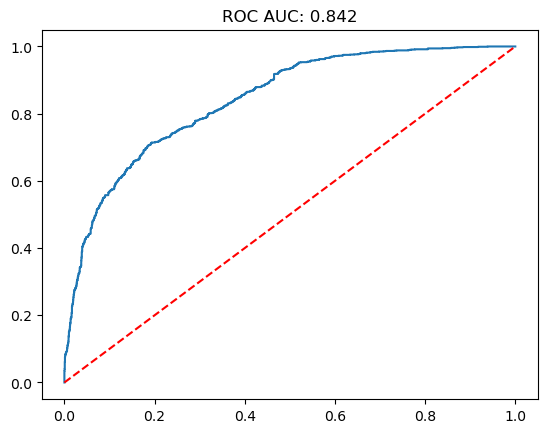

Do you want to save this model? Y/N y


In [142]:
model_validation(LogisticRegression(class_weight='balanced'),x_train,y_train,x_test,y_test)

In [144]:
scorecard

,Model,Accuracy,Recall,Precison,F1 Score,Cohen-Kappa
0,LogisticRegression(class_weight='balanced'),0.692437,0.846667,0.525336,0.648373,0.400614


### Naive Bayes

[[1416  967]
 [ 284  916]]
              precision    recall  f1-score   support

           0       0.83      0.59      0.69      2383
           1       0.49      0.76      0.59      1200

    accuracy                           0.65      3583
   macro avg       0.66      0.68      0.64      3583
weighted avg       0.72      0.65      0.66      3583



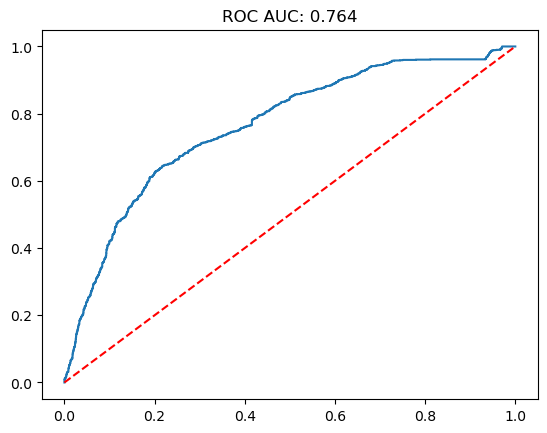

Do you want to save this model? Y/N y


In [147]:
model_validation(GaussianNB(),x_train,y_train,x_test,y_test)

[[2004  379]
 [ 711  489]]
              precision    recall  f1-score   support

           0       0.74      0.84      0.79      2383
           1       0.56      0.41      0.47      1200

    accuracy                           0.70      3583
   macro avg       0.65      0.62      0.63      3583
weighted avg       0.68      0.70      0.68      3583



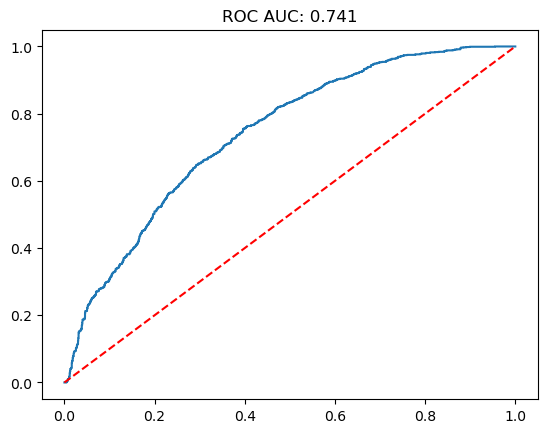

Do you want to save this model? Y/N y


In [149]:
model_validation(MultinomialNB(),x_train,y_train,x_test,y_test)

[[2383    0]
 [1200    0]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80      2383
           1       0.00      0.00      0.00      1200

    accuracy                           0.67      3583
   macro avg       0.33      0.50      0.40      3583
weighted avg       0.44      0.67      0.53      3583



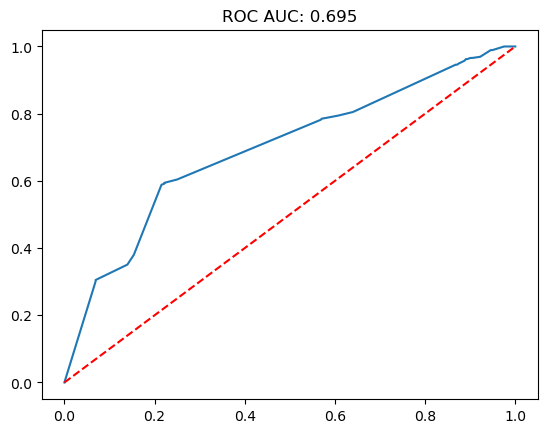

Do you want to save this model? Y/N y


In [151]:
model_validation(BernoulliNB(),x_train,y_train,x_test,y_test)

In [153]:
scorecard

,Model,Accuracy,Recall,Precison,F1 Score,Cohen-Kappa
0,LogisticRegression(class_weight='balanced'),0.692437,0.846667,0.525336,0.648373,0.400614
1,GaussianNB(),0.650851,0.763333,0.486458,0.594226,0.313283
2,MultinomialNB(),0.695786,0.407500,0.563364,0.472921,0.266777
3,BernoulliNB(),0.665085,0.000000,0.000000,0.000000,0.000000


### Decision Tree

[[2150  233]
 [ 349  851]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2383
           1       0.79      0.71      0.75      1200

    accuracy                           0.84      3583
   macro avg       0.82      0.81      0.81      3583
weighted avg       0.84      0.84      0.84      3583



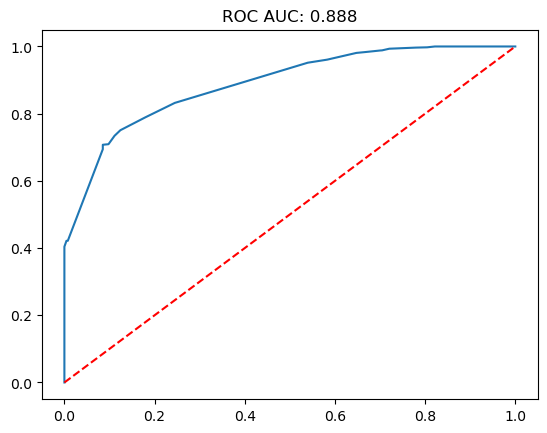

Do you want to save this model? Y/N y


In [156]:
model_validation(DecisionTreeClassifier(max_depth=5),x_train,y_train,x_test,y_test)

In [158]:
# Fine tune DT

grid = {'max_depth':[4,5,6,7,8,9,10]}

gscv = GridSearchCV(estimator=DecisionTreeClassifier(),cv=5,scoring='roc_auc',
                   verbose=1,param_grid=grid)

In [160]:
gscv.fit(x_train,y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10]},
             scoring='roc_auc', verbose=1)

In [161]:
gscv.best_params_

{'max_depth': 6}

[[2063  320]
 [ 276  924]]
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      2383
           1       0.74      0.77      0.76      1200

    accuracy                           0.83      3583
   macro avg       0.81      0.82      0.81      3583
weighted avg       0.84      0.83      0.83      3583



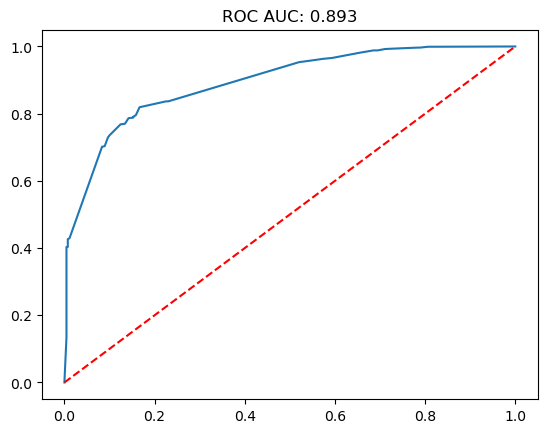

Do you want to save this model? Y/N y


In [164]:
model_validation(DecisionTreeClassifier(**gscv.best_params_),x_train,y_train,x_test,y_test)

In [166]:
scorecard

,Model,Accuracy,Recall,Precison,F1 Score,Cohen-Kappa
0,LogisticRegression(class_weight='balanced'),0.692437,0.846667,0.525336,0.648373,0.400614
1,GaussianNB(),0.650851,0.763333,0.486458,0.594226,0.313283
2,MultinomialNB(),0.695786,0.407500,0.563364,0.472921,0.266777
3,BernoulliNB(),0.665085,0.000000,0.000000,0.000000,0.000000
4,DecisionTreeClassifier(max_depth=5),0.837566,0.709167,0.785055,0.745184,0.626421
5,DecisionTreeClassifier(max_depth=6),0.833659,0.770000,0.742765,0.756137,0.629982


### Random Forest

In [169]:
grid = {'n_estimators':[110,120,130],
       'max_depth':[4,5,6]}

gscv = GridSearchCV(estimator=RandomForestClassifier(),cv=5,scoring='roc_auc',
                   verbose=1,param_grid=grid)

In [171]:
gscv.fit(x_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 5, 6],
                         'n_estimators': [110, 120, 130]},
             scoring='roc_auc', verbose=1)

In [172]:
gscv.best_params_

{'max_depth': 6, 'n_estimators': 120}

[[2187  196]
 [ 348  852]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      2383
           1       0.81      0.71      0.76      1200

    accuracy                           0.85      3583
   macro avg       0.84      0.81      0.82      3583
weighted avg       0.85      0.85      0.85      3583



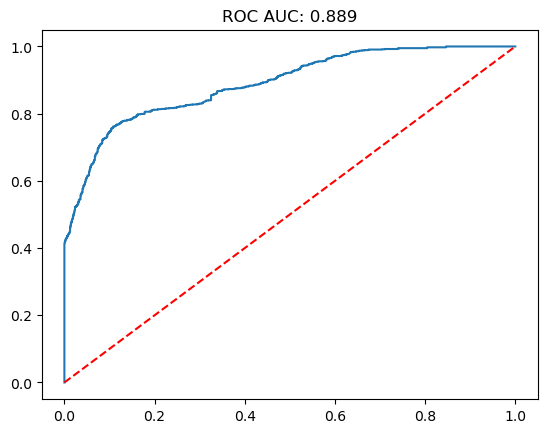

Do you want to save this model? Y/N y


In [173]:
model_validation(RandomForestClassifier(**gscv.best_params_),
                 x_train,y_train,x_test,y_test)

In [174]:
scorecard

,Model,Accuracy,Recall,Precison,F1 Score,Cohen-Kappa
0,LogisticRegression(class_weight='balanced'),0.692437,0.846667,0.525336,0.648373,0.400614
1,GaussianNB(),0.650851,0.763333,0.486458,0.594226,0.313283
2,MultinomialNB(),0.695786,0.407500,0.563364,0.472921,0.266777
3,BernoulliNB(),0.665085,0.000000,0.000000,0.000000,0.000000
4,DecisionTreeClassifier(max_depth=5),0.837566,0.709167,0.785055,0.745184,0.626421
5,DecisionTreeClassifier(max_depth=6),0.833659,0.770000,0.742765,0.756137,0.629982
6,"RandomForestClassifier(max_depth=6, n_estimato...",0.848172,0.710000,0.812977,0.758007,0.648128


### AdaBoost

[[2054  329]
 [ 344  856]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2383
           1       0.72      0.71      0.72      1200

    accuracy                           0.81      3583
   macro avg       0.79      0.79      0.79      3583
weighted avg       0.81      0.81      0.81      3583



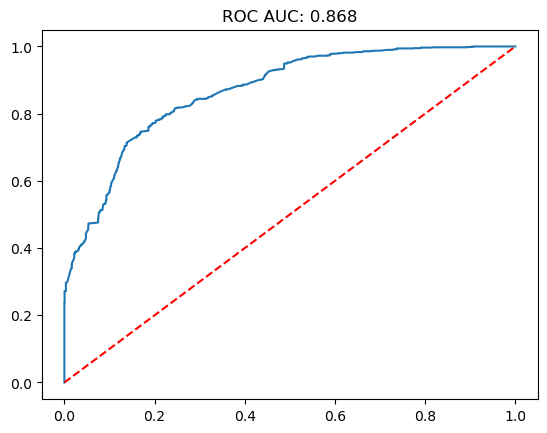

Do you want to save this model? Y/N y


In [176]:
model_validation(AdaBoostClassifier(n_estimators=150,learning_rate=0.1),
                x_train,y_train,x_test,y_test)

In [177]:
scorecard

,Model,Accuracy,Recall,Precison,F1 Score,Cohen-Kappa
0,LogisticRegression(class_weight='balanced'),0.692437,0.846667,0.525336,0.648373,0.400614
1,GaussianNB(),0.650851,0.763333,0.486458,0.594226,0.313283
2,MultinomialNB(),0.695786,0.407500,0.563364,0.472921,0.266777
3,BernoulliNB(),0.665085,0.000000,0.000000,0.000000,0.000000
4,DecisionTreeClassifier(max_depth=5),0.837566,0.709167,0.785055,0.745184,0.626421
5,DecisionTreeClassifier(max_depth=6),0.833659,0.770000,0.742765,0.756137,0.629982
6,"RandomForestClassifier(max_depth=6, n_estimato...",0.848172,0.710000,0.812977,0.758007,0.648128
7,"AdaBoostClassifier(learning_rate=0.1, n_estima...",0.812169,0.713333,0.722363,0.717820,0.577063


### XGBoost

[[1998  385]
 [ 254  946]]
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      2383
           1       0.71      0.79      0.75      1200

    accuracy                           0.82      3583
   macro avg       0.80      0.81      0.80      3583
weighted avg       0.83      0.82      0.82      3583



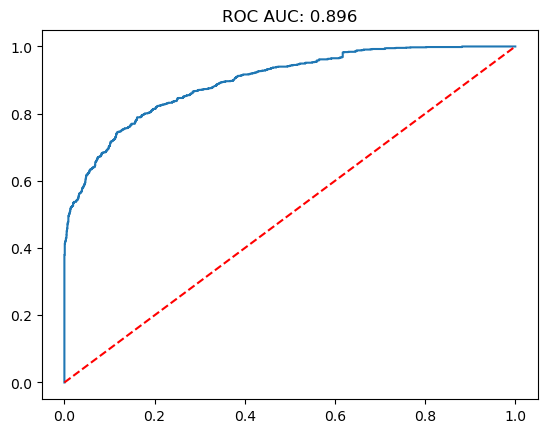

Do you want to save this model? Y/N y


In [179]:
model_validation(XGBClassifier(n_estimators=80,max_depth=9,learning_rate=0.5),
                x_train,y_train,x_test,y_test)

In [180]:
scorecard

,Model,Accuracy,Recall,Precison,F1 Score,Cohen-Kappa
0,LogisticRegression(class_weight='balanced'),0.692437,0.846667,0.525336,0.648373,0.400614
1,GaussianNB(),0.650851,0.763333,0.486458,0.594226,0.313283
2,MultinomialNB(),0.695786,0.407500,0.563364,0.472921,0.266777
3,BernoulliNB(),0.665085,0.000000,0.000000,0.000000,0.000000
4,DecisionTreeClassifier(max_depth=5),0.837566,0.709167,0.785055,0.745184,0.626421
5,DecisionTreeClassifier(max_depth=6),0.833659,0.770000,0.742765,0.756137,0.629982
6,"RandomForestClassifier(max_depth=6, n_estimato...",0.848172,0.710000,0.812977,0.758007,0.648128
7,"AdaBoostClassifier(learning_rate=0.1, n_estima...",0.812169,0.713333,0.722363,0.717820,0.577063
8,"XGBClassifier(base_score=None, booster=None, c...",0.821658,0.788333,0.710744,0.747531,0.610237


In [181]:
# Lets check for the variance in DT and XGB

In [182]:
from sklearn.model_selection import cross_val_score,KFold

### Practice

In [184]:
scores = cross_val_score(estimator=DecisionTreeClassifier(max_depth=6),X=x_train,y=y_train,cv=6,scoring='f1')

In [185]:
scores

array([0.78633005, 0.7640665 , 0.55729387, 0.38906414, 0.68565879,
       0.73358209])

In [186]:
scores = cross_val_score(estimator=XGBClassifier(n_estimators=70,learning_rate=0.05,max_depth=7,reg_lambda=5),X=x_train,y=y_train,cv=6,scoring='f1')

In [187]:
scores

array([0.79029247, 0.76499508, 0.55102975, 0.34179894, 0.69710097,
       0.75104312])

In [188]:
scores = cross_val_score(estimator=RandomForestClassifier(max_depth=7),X=x_train,y=y_train,cv=6,scoring='f1')

In [189]:
scores

array([0.80040323, 0.77766497, 0.48338082, 0.29909707, 0.64411765,
       0.74383708])

### Voting Classifier

In [191]:
base_model= [('DT1',DecisionTreeClassifier(max_depth=5)),
            ('DT2',DecisionTreeClassifier(max_depth=6)),
            ('XGB1',XGBClassifier(n_estimators=70,learning_rate=0.1,max_depth=5)),
            ('XGB2',XGBClassifier(n_estimators=70,learning_rate=0.05,max_depth=5))]

[[2141  242]
 [ 281  919]]
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2383
           1       0.79      0.77      0.78      1200

    accuracy                           0.85      3583
   macro avg       0.84      0.83      0.83      3583
weighted avg       0.85      0.85      0.85      3583



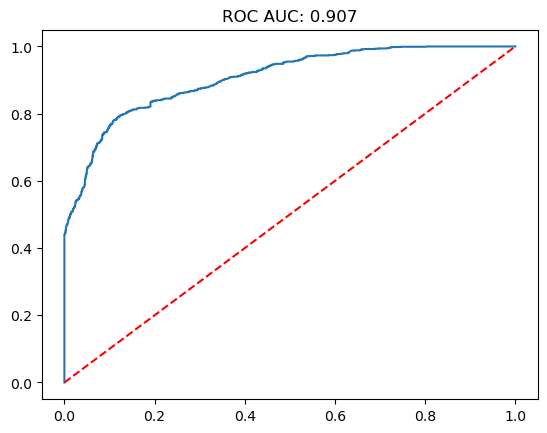

Do you want to save this model? Y/N y


In [192]:
model_validation(VotingClassifier(estimators=base_model,voting='soft'),x_train,y_train,x_test,y_test)

In [193]:
scores = cross_val_score(estimator=VotingClassifier(estimators=base_model),X=x_train,y=y_train,cv=7,scoring='f1')

In [194]:
scores

array([0.80588919, 0.81343586, 0.63681146, 0.27230668, 0.56795132,
       0.71016692, 0.72828891])

In [195]:
scorecard

,Model,Accuracy,Recall,Precison,F1 Score,Cohen-Kappa
0,LogisticRegression(class_weight='balanced'),0.692437,0.846667,0.525336,0.648373,0.400614
1,GaussianNB(),0.650851,0.763333,0.486458,0.594226,0.313283
2,MultinomialNB(),0.695786,0.407500,0.563364,0.472921,0.266777
3,BernoulliNB(),0.665085,0.000000,0.000000,0.000000,0.000000
4,DecisionTreeClassifier(max_depth=5),0.837566,0.709167,0.785055,0.745184,0.626421
5,DecisionTreeClassifier(max_depth=6),0.833659,0.770000,0.742765,0.756137,0.629982
6,"RandomForestClassifier(max_depth=6, n_estimato...",0.848172,0.710000,0.812977,0.758007,0.648128
7,"AdaBoostClassifier(learning_rate=0.1, n_estima...",0.812169,0.713333,0.722363,0.717820,0.577063
8,"XGBClassifier(base_score=None, booster=None, c...",0.821658,0.788333,0.710744,0.747531,0.610237
9,"VotingClassifier(estimators=[('DT1', DecisionT...",0.854033,0.765833,0.791559,0.778484,0.669683


## Stacking

[[2157  226]
 [ 278  922]]
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2383
           1       0.80      0.77      0.79      1200

    accuracy                           0.86      3583
   macro avg       0.84      0.84      0.84      3583
weighted avg       0.86      0.86      0.86      3583



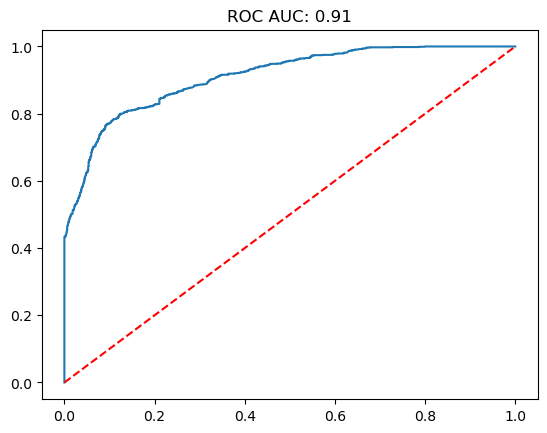

Do you want to save this model? Y/N y


In [198]:
model_validation(StackingClassifier(estimators=base_model),x_train,y_train,x_test,y_test)

In [199]:
scorecard

,Model,Accuracy,Recall,Precison,F1 Score,Cohen-Kappa
0,LogisticRegression(class_weight='balanced'),0.692437,0.846667,0.525336,0.648373,0.400614
1,GaussianNB(),0.650851,0.763333,0.486458,0.594226,0.313283
2,MultinomialNB(),0.695786,0.407500,0.563364,0.472921,0.266777
3,BernoulliNB(),0.665085,0.000000,0.000000,0.000000,0.000000
4,DecisionTreeClassifier(max_depth=5),0.837566,0.709167,0.785055,0.745184,0.626421
5,DecisionTreeClassifier(max_depth=6),0.833659,0.770000,0.742765,0.756137,0.629982
6,"RandomForestClassifier(max_depth=6, n_estimato...",0.848172,0.710000,0.812977,0.758007,0.648128
7,"AdaBoostClassifier(learning_rate=0.1, n_estima...",0.812169,0.713333,0.722363,0.717820,0.577063
8,"XGBClassifier(base_score=None, booster=None, c...",0.821658,0.788333,0.710744,0.747531,0.610237
9,"VotingClassifier(estimators=[('DT1', DecisionT...",0.854033,0.765833,0.791559,0.778484,0.669683


In [200]:
scores= cross_val_score(estimator=StackingClassifier(estimators=base_model),X=x_train,y=y_train,cv=7,scoring='f1')

In [201]:
scores

array([0.79777778, 0.79937912, 0.65602688, 0.27243383, 0.57171315,
       0.70485584, 0.75208681])

In [202]:
# Lets try and tune random forest

[[2144  239]
 [ 342  858]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2383
           1       0.78      0.71      0.75      1200

    accuracy                           0.84      3583
   macro avg       0.82      0.81      0.81      3583
weighted avg       0.84      0.84      0.84      3583



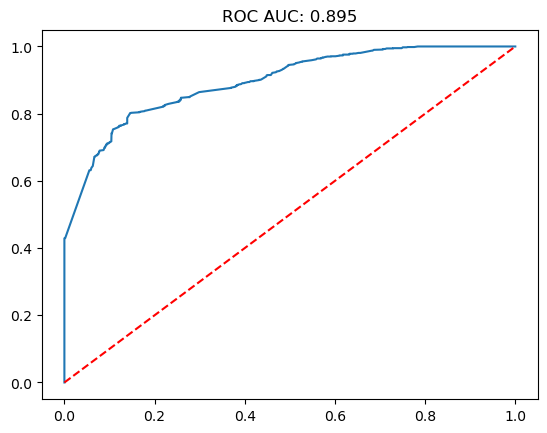

Do you want to save this model? Y/N y


In [203]:
model_validation(RandomForestClassifier(n_estimators=100,max_features=None,max_depth=5),x_train,y_train,x_test,y_test)

In [204]:
scores=cross_val_score(estimator=RandomForestClassifier(n_estimators=100,max_features=None,max_depth=6,class_weight='balanced'),X=x_train,y=y_train,cv=KFold(n_splits=7,random_state=2,shuffle=True),scoring='f1')
scores

array([0.7385304 , 0.73586367, 0.74600078, 0.75836431, 0.75120504,
       0.77567668, 0.73790166])

## hgj

In [206]:
scores=cross_val_score(estimator=DecisionTreeClassifier(max_depth=5),X=x_train,y=y_train,cv=KFold(n_splits=7,random_state=2,shuffle=True),scoring='f1')
scores

array([0.68663388, 0.67973856, 0.66790698, 0.68402471, 0.70026762,
       0.71774892, 0.6641895 ])

In [207]:
scores=cross_val_score(estimator=DecisionTreeClassifier(max_depth=6),X=x_train,y=y_train,cv=KFold(n_splits=7,random_state=2,shuffle=True),scoring='f1')
scores

array([0.72575947, 0.72561769, 0.72742833, 0.70973085, 0.71945509,
       0.73004797, 0.70439189])

In [208]:
scores_xgb1=cross_val_score(estimator=XGBClassifier(n_estimators=70,learning_rate=0.1,max_depth=7),X=x_train,y=y_train,cv=KFold(n_splits=7,random_state=2,shuffle=True),scoring='f1')
scores

array([0.72575947, 0.72561769, 0.72742833, 0.70973085, 0.71945509,
       0.73004797, 0.70439189])

In [209]:
scores_xgb2=cross_val_score(estimator=XGBClassifier(n_estimators=70,learning_rate=0.05,max_depth=5),X=x_train,y=y_train,cv=KFold(n_splits=7,random_state=2,shuffle=True),scoring='f1')
scores

array([0.72575947, 0.72561769, 0.72742833, 0.70973085, 0.71945509,
       0.73004797, 0.70439189])

In [210]:
scores_xgb1.mean()

0.7881199884645845

In [211]:
scores_xgb2.mean()

0.7472187318701143

In [212]:
scores_xgb1.std()/scores_xgb1.mean()

0.01626431028045309

In [213]:
scores_xgb2.std()/scores_xgb2.mean()

0.01957815276682263

### Voting

In [215]:
base_model= [('DT1',DecisionTreeClassifier(max_depth=5)),
            ('DT2',DecisionTreeClassifier(max_depth=6)),
            ('XGB1',XGBClassifier(n_estimators=70,learning_rate=0.1,max_depth=5)),
            ('XGB2',XGBClassifier(n_estimators=70,learning_rate=0.05,max_depth=5))]

[[2141  242]
 [ 281  919]]
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2383
           1       0.79      0.77      0.78      1200

    accuracy                           0.85      3583
   macro avg       0.84      0.83      0.83      3583
weighted avg       0.85      0.85      0.85      3583



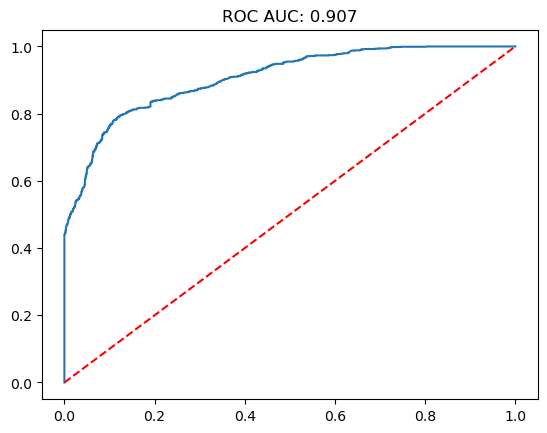

Do you want to save this model? Y/N y


In [216]:
model_validation(VotingClassifier(estimators=base_model,voting='soft'),x_train,y_train,x_test,y_test)

In [217]:
score_vot=cross_val_score(estimator=VotingClassifier(estimators=base_model,voting='soft'),X=x_train,y=y_train,cv=KFold(n_splits=7,random_state=2,shuffle=True),scoring='f1')
score_vot

array([0.74288179, 0.73870682, 0.74060981, 0.74706868, 0.75734677,
       0.76385337, 0.71883289])

In [218]:
score_vot.std()/score_vot.mean()

0.017996890357321826

In [219]:
score_vot.mean()

0.7441857325217189

## Stacking

In [221]:
score_stack=cross_val_score(estimator=StackingClassifier(estimators=base_model),X=x_train,y=y_train,cv=KFold(n_splits=7,random_state=2,shuffle=True),scoring='f1')
score_stack

array([0.75497835, 0.73309288, 0.74402126, 0.74978939, 0.75982906,
       0.77674024, 0.73294695])

In [222]:
score_stack.mean()

0.7501997311103608

In [223]:
score_stack.std()/score_stack.mean()

0.019175589316401467

### Lets finalize XGB1 and fine tune it further

In [225]:
grid={'n_estimators':[70,80],
     'learning_rate':[0.1,0.7,0.5],
     'max_depth':[6,7,8,9]}

In [226]:
gscv=GridSearchCV(estimator=XGBClassifier(),param_grid=grid,cv=KFold(n_splits=7,shuffle=True,random_state=2),scoring='f1',verbose=1)

In [227]:
gscv.fit(x_train,y_train)

Fitting 7 folds for each of 24 candidates, totalling 168 fits


GridSearchCV(cv=KFold(n_splits=7, random_state=2, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     inte...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.7, 0.5],
                         'max_depth': [6, 7, 8, 9], 'n_estimators': [70, 80]},
             scoring='f1', verbose=1)

In [228]:
gscv.best_score_

0.8115865560238872

In [229]:
gscv.best_params_

{'learning_rate': 0.5, 'max_depth': 9, 'n_estimators': 80}

In [280]:
cross_val_score(estimator=XGBClassifier(**gscv.best_params_),X=x_train,y=y_train,cv=KFold(n_splits=7,shuffle=True,random_state=2),scoring='roc_auc',verbose=1)

array([0.94008543, 0.93857734, 0.93900335, 0.93682184, 0.94434476,
       0.9452575 , 0.93868397])

## Business Interpretation

In [288]:
f1_data=pd.DataFrame(final_model.feature_importances_,index=x_train.columns).sort_values(by=0,ascending=False)
f1_data

,0
market_segment_type,0.345702
required_car_parking_space,0.229031
no_of_special_requests,0.154326
lead_time,0.084419
no_of_adults,0.061135
avg_price_per_room,0.053059
no_of_weekend_nights,0.039008
no_of_week_nights,0.033320


<Axes: >

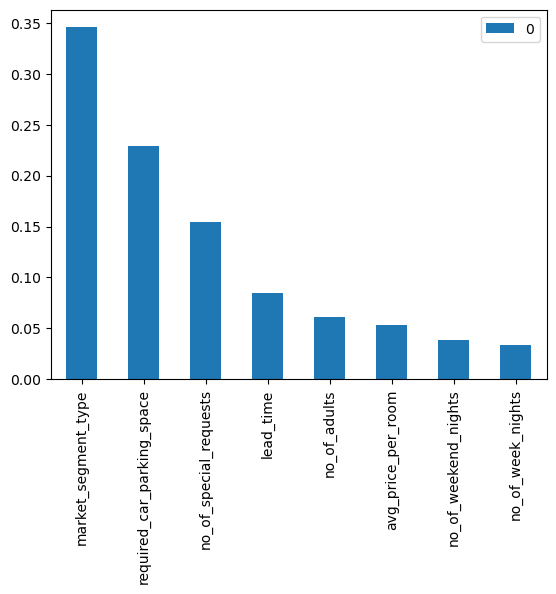

In [290]:
f1_data.plot(kind='bar')

## Deployment

In [284]:
final_model= XGBClassifier(**gscv.best_params_)
final_model.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=80, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [292]:
lt=30
mst=1
spcl=1
price=200
adults=2
wkend=2
park=0
wk=0


In [294]:
tran_data=pt.transform([[lt,price]])
lt_t=tran_data[0][0]
price_t=tran_data[0][1]

In [296]:
final_model.predict([[lt_t,mst,spcl,price_t,adults,wkend,park,wk]])

array([0])

In [298]:
final_model.predict_proba([[lt_t,mst,spcl,price_t,adults,wkend,park,wk]])[:,1]

array([0.32065347], dtype=float32)

In [300]:
# lets save the fitted model and Transformer instance
import pickle 

In [302]:
with open('final_model_xgb.pkl','wb') as file:
    pickle.dump(final_model,file)

In [304]:
with open('transformer.pkl','wb') as file:
    pickle.dump(pt,file)